# Words and Brains - Basic Features

Welcome to my WordGame project! In this first notebook, we are going to divide the people in this dataset into two neuro-classes and extract some features basic features, such as average word length, for each of these classes.
 
Let's open up the dataset.

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting
import seaborn as sns #data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input/wordgame"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [21]:
pal = sns.color_palette()

#df = pd.read_csv('../input/wordgame/wordgame_20170628.csv', dtype='object')
df = pd.read_csv('../data/processed/wordgame_20170628.csv', dtype='object')
#store words as string
df['word1'] = df['word1'].astype('str') 
df['word2'] = df['word2'].astype('str') 

# convert all words to lowercase
df['word1'] = df['word1'].map(str).apply(lambda x: x.lower())
df['word2'] = df['word2'].map(str).apply(lambda x: x.lower())

#print first rows
df.head()

,author,word1,word2,source
0,1203,jailed,imprisoned,ecig
1,5839,me,liverbird,wrongplanet
2,2962,reach,up,sas
3,1066,owie,band-aid,ecig
4,5006,water,river,wrongplanet


Some word association are really obvious (e.g. jailed -> imprisoned), whereas as others are absolutely not (e.g. ME -> Liverbird?). 

## Sources
We have data from 10 sources. 23% of the data was purposely scraped from autism-related websites, Aspies Central and Wrong Planet. Research has shown that persons with an ASD have different brain structure and functionality compared to persons with a neuro-typical (NT) brain, which may lead to different behaviour whilst playing an online Word Association Game. Since we do not have of diagnosical data of all persons in the dataset, we will make the assumption that everyone from the Aspies Central and Wrong Planet communities have autism, and all users from other communities do not have autism. In reality approximately 10% of all people have autism, and these people will also be present on non-autism related websites, while also not everyone in a autism-related community has autism themselves (for example NT parents seeking for advise for their autistic child). Thus this assumption will be approximately 90% correct.

In [22]:
# create a source ID 
df['sourceID'] = df['source'].astype('category').cat.codes

#returns False for sources 0 (AspiesCentral) and 9 (WrongPlanet) and True for others. 
def isNt(r):
	return ((r.sourceID%9)>0)

#group sources based on (assumed) brain-structure of their users (neural-typical versus ASD)
df['nt'] = df.apply(isNt, axis=1)
print("Number of NT-pairs: " + str(len(df[df['nt']])))
print("Number of ASD-pairs: " + str(len(df[df['nt']==False])))

Number of NT-pairs: 259792
Number of ASD-pairs: 74244


# Term frequency

In [64]:
#doc length normalization!?
#.value_counts()['myword']

#10 documents
#term frequency without normalization
df['tf10_wn'] = df.groupby(['word1','source'])['word1'].transform('count')

# normalized term frequency
N10 = df.sourceID.value_counts(sort=False).tolist()

def normTF10(r):
    return r.tf10_wn/(N10[r.sourceID])

df['tf10'] = df.apply(normTF10, axis=1)
#df.drop('tf10_wn', 1)

#2 documents
df['tf2_wn'] = df.groupby(['word1','nt'])['word1'].transform('count')

# normalized term frequency
N2 = df.nt.value_counts(sort=False).tolist()

def normTF2(r):
    return r.tf2_wn/(N2[r.nt])

df['tf2'] = df.apply(normTF2, axis=1)
#df.drop('tf2_wn', 1)

print("Number of unique words : " + str(len(df['word1'].unique())))
print("Mean term frequency (word1): " + str(df['tf10'].mean()))
print("Median term frequency (word1): " + str(df['tf10'].median()))

print("NT vs. ASD")
print("\tMean term frequency (word1): " + str(df['tf2'].mean()))
print("\tMedian term frequency (word1): " + str(df['tf2'].median()))


Number of unique words : 60862
Mean term frequency (word1): 0.000252927754057
Median term frequency (word1): 0.00012033513334636964
NT vs. ASD
	Mean term frequency (word1): 0.00019317817985
	Median term frequency (word1): 8.468313112028084e-05


Skewed. Small: large datasets

334036


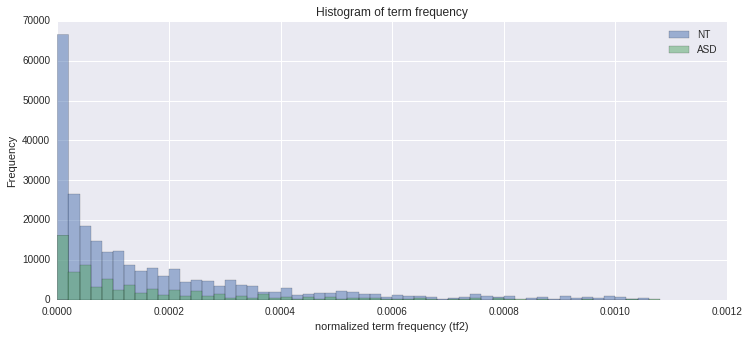

In [77]:
#print(df.groupby(['word1'])['word1'].transform('count').median())
#print(df.tf2_wn.median())

#
sample = df#[df['tf2_wn']>15]
print(len(sample))

## plot word length histogram
nt = sample[sample['nt']==True].tf2
asd = sample[sample['nt']==False].tf2

w1 = np.ones_like(nt)#/len(nt)
w2 = np.ones_like(asd)#/len(asd)

bins = np.arange(0,0.0011,0.00002)

plt.figure(figsize=(12, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
#plt.yscale('log')
plt.title('Histogram of term frequency')
plt.xlabel('normalized term frequency (tf2)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
#axes.set_xlim([0,0.0003])
#axes.set_ylim([0,0.6])
plt.show()

The ASD set contains more words with a low term frequency. This frequency is normalized by dividing the raw term count by the dataset size, so this is not due to the smaller size of the ASD dataset. Appearantly ASD'ers use more relatively uncommon words. 

# Document frequency


In [82]:
#create postings lists
aspieslist = (df['word1'][df['source']=="aspiecentral"]).unique().tolist()
atu2list = (df['word1'][df['source']=="atu2"]).unique().tolist()
bleeplist = (df['word1'][df['source']=="bleeping_computer"]).unique().tolist()
comicslist = (df['word1'][df['source']=="classic_comics"]).unique().tolist()
eciglist = (df['word1'][df['source']=="ecig"]).unique().tolist()
goglist = (df['word1'][df['source']=="gog"]).unique().tolist()
englishlist = (df['word1'][df['source']=="learn_english"]).unique().tolist()
saslist = (df['word1'][df['source']=="sas"]).unique().tolist()
fishlist = (df['word1'][df['source']=="the_fishy"]).unique().tolist()
wronglist = (df['word1'][df['source']=="wrongplanet"]).unique().tolist()

df['df10'] = (df['word1'].isin(aspieslist).astype(int) + df['word1'].isin(atu2list).astype(int) 
             + df['word1'].isin(bleeplist).astype(int) + df['word1'].isin(comicslist).astype(int)
             + df['word1'].isin(eciglist).astype(int) + df['word1'].isin(goglist).astype(int)
             + df['word1'].isin(englishlist).astype(int) + df['word1'].isin(saslist).astype(int)
             + df['word1'].isin(fishlist).astype(int) + df['word1'].isin(wronglist).astype(int))

ntlist = (df['word1'][df['nt']==True]).unique().tolist()
asdlist = (df['word1'][df['nt']==False]).unique().tolist()
df['df2'] = (df['word1'].isin(ntlist).astype(int) + df['word1'].isin(asdlist).astype(int))

print(df.df10.head())

0     2
1    10
2     5
3     2
4    10
Name: df10, dtype: int64


# Pair frequency!

In [80]:
#concatenate word1 and word2 separated by a special character which does not appear in the words itself
def concat(r):
    return r.word1 + ":" + r.word2

#normalization!!
df['pair'] = df.apply(concat, axis=1)

df['pf'] = df.groupby(['pair'])['pair'].transform('count')
df['pf2'] = df.groupby(['pair','nt'])['pair'].transform('count')
df['pf10'] = df.groupby(['pair','source'])['pair'].transform('count')

print("Number of unique pairs : " + str(len(df['pair'].unique())))

#10s
print("Mean pair frequency: " + str(df['pf10'].mean()))
print("Median pair frequency: " + str(df['pf10'].median()))

freq_pairs = df.sort_values(by=['pf'], ascending=False)['pair'].unique().tolist()

print("Top 20 most frequent word pairs: \n\t"+str(freq_pairs[0:20]))

Number of unique pairs : 249951
Mean pair frequency: 1.40698607336
Median pair frequency: 1.0
Top 20 most frequent word pairs: 
	['me:you', 'man:woman', 'up:down', 'time:clock', 'meow:meow', 'green:grass', 'dog:cat', 'house:home', 'lost:found', 'out:in', 'down:under', 'life:death', 'book:worm', 'out:side', 'doctor:who', 'day:night', 'red:blood', 'movie:film', 'king:queen', 'love:hate']


# TFIDF

In [87]:
#smoothed

#although unsmoothed also provides interesting insights (all words in all 10 documents are ignored)
# explain 10+1 and 2+3
def tfidf10(r):
    return (r.tf10)*(np.log(1+(10/r.df10)))

#numpy log = math.log?? =?
df['tfidf10'] = df.apply(tfidf10, axis=1)


def tfidf2(r):
    return (r.tf2)*(np.log(1+(2/r.df2)))

#numpy log = math.log?? =?
df['tfidf2'] = df.apply(tfidf2, axis=1)

#print(df['tfidf10'].head(60))
#print(df['tfidf2'].head(60))

In [8]:
temp = df.sort_values(by=['tfidf10'], ascending=False)
for i in range(0,10):
    tslice = temp[temp['sourceID']==i]
    print(tslice['source'].head(1))
    tslice = tslice['word1'].unique()
    print(tslice[0:10])
    

326738    aspiecentral
Name: source, dtype: object
['music' 'dog' 'fish' 'cat' 'chocolate' 'man' 'game' 'water' 'house' 'time']
319118    atu2
Name: source, dtype: object
['bono' 'u2' 'love' 'music' 'the edge' 'me' 'macphisto' 'green'
 "visitors can't see pics" 'money']
254002    bleeping_computer
Name: source, dtype: object
['time' 'food' 'head' 'cake' 'music' 'pie' 'ball' 'fish' 'water' 'ship']
307084    classic_comics
Name: source, dtype: object
['man' 'water' 'dog' 'house' 'bird' 'black' 'money' 'power' 'cat' 'game']
184902    ecig
Name: source, dtype: object
['out' 'down' 'ball' 'house' 'up' 'deter' 'happy' 'fire' 'play' 'party']
61872    gog
Name: source, dtype: object
['dickory' "ninja'd" 'water' 'death' 'game' 'time' 'fire' 'food' 'space'
 'music']
63897    learn_english
Name: source, dtype: object
['love' 'life' 'winter' 'music' 'fun' 'food' 'mother' 'night' 'soul' 'cold']
73938    sas
Name: source, dtype: object
['water' 'time' 'house' 'music' 'light' 'down' 'car' 'life' 'bal

OMG wrongplanet is sooo nerdy O_o

# PFIDF



In [84]:
def pfidf10(r):
    return (r.pf10)*(np.log(10/r.df10))

#numpy log = math.log?? =?
df['pfidf10'] = df.apply(pfidf10, axis=1)

temp = df.sort_values(by=['pfidf10'], ascending=False)
for i in range(0,10):
    tslice = temp[temp['sourceID']==i]
    tslice = tslice['pair'].unique()
    print(tslice[0:10])
    
def pfidf2(r):
    return (r.pf2)*(np.log(2/r.df2))

#numpy log = math.log?? =?
df['pfidf2'] = df.apply(pfidf2, axis=1)



['gasket:seal' 'fargo:bank' 'rutgers:university' 'my word:my word'
 'reenactment:civil war' 'standard deviation:math' 'walkie talkie:patient'
 'galactica:pegasus' 'the old country:ireland' 'thunderstorms:lightning']
['no line on the horizon:magnificent' 'bono:edge' "o'connell street:dublin"
 'guitar hero:the edge' 'brad pitt:angelina jolie' 'bono:vox'
 "the claw:edge's spaceship" "bono:o'connell street" 'bono:glasses'
 'dublin:ireland']
['epidermis:skin' 'bleeping:sound' 'concourse:airport' 'zorba:ouzo'
 'basketbtw:basketbtw' 'ivories:elephant' 'solver:detective' 'sass:afrass'
 'heals:wounds' 'litigation:court']
['nathaniel:hawthorne' 'jerry lewis:dean martin' 'irving:forbush'
 'encounters:brief' 'wight:barrow' 'simon:says' 'scrotum:sac' 'emma:frost'
 'peregrine:france' 'masking:tape']
['plugged:up' 'grabbed:snatched' 'racks:shelves' 'deter:dissuade'
 'demonstrate:exhibit' 'came:went' 'harass:bother' 'bother:pester'
 'squeal:pig' 'jubilant:happy']
['kombat:mortal' 'dollie:tuna' 'pussy:

# Plot

82291


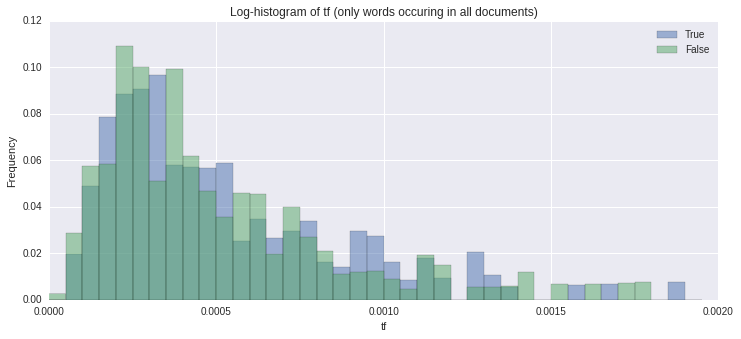

In [121]:
sample = df[df['df10']>9] #garbage out
print(len(sample))

bins = np.arange(0,0.002,0.00005)

plt.figure(figsize=(12, 5))

for i in reversed(range(0,2)):
    s = sample[sample['nt']==i]
    tfidf = s.tf2
    #print(s.head())
    plt.hist(tfidf, bins=bins, alpha=0.5, label=str(s.iloc[0]['nt']), weights=(np.ones_like(tfidf)/len(tfidf)))  

for i in range(0,10,9):
    s = sample[sample['sourceID']==i]
    tfidf = s.tfidf10
    #plt.hist(tfidf, bins=bins, alpha=0.3, label=s.iloc[0]['source'], weights=(np.ones_like(tfidf)/len(tfidf)))  


#plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
#plt.yscale('log')
plt.title('Log-histogram of tf (only words occuring in all documents)')
plt.xlabel('tf')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
#axes.set_xlim([-5,160])
plt.show()

buhbuh :(

to do make a nice plot:

https://juliasilge.com/blog/term-frequency-tf-idf/ 

maybe df is better?

In [13]:
print(df[df['nt']].df10.mean())
print(df[df['nt']==False].df10.mean())

6.56239222147
6.35056031464


## Word length
We are now ready to extract our first feature, which will be the word length. I do not expect any differences between NT'ers and ASD'ers, although I'm curious to what is the average length of English words. 

Longest word: 200


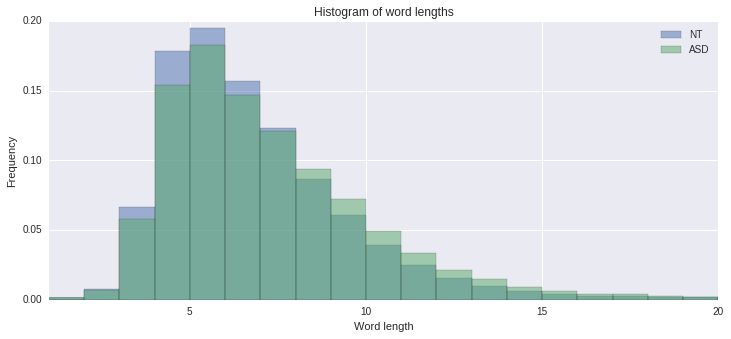

In [14]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))
print("Longest word: " +str(df['len1'].max()))

## plot word length histogram
nt = df[df['nt']].len1
asd = df[df['nt']==False].len1

w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

bins = np.arange(1,30)

plt.figure(figsize=(12, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
plt.title('Histogram of word lengths')
plt.xlabel('Word length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([1,20])
plt.show()

A post contains on average 7 characters. Most words are between 3 and 15 characters long. The longest word (although it is probably a sentence) is 200 characters long. Interestingly, both NT'ers and ASD'ers use words with exactly 7 characters with similar frequency although **ASD'ers tend to use words shorter than 7 characters less frequently and longer words slightly more frequently.**

## Word length difference
We can also look at the difference between the word lenght of word1 and word2.



In [ ]:
df['d_len'] = np.abs(df.len1 - df.len2)

## plot word length histogram
nt = df[df['nt']].d_len
asd = df[df['nt']==False].d_len

w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

bins = np.arange(0,20)

plt.figure(figsize=(12, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
plt.title('Histogram of word lengths')
plt.xlabel('Word length difference')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([0,15])
plt.show()

Consistent with word length..

In [ ]:
df['d_len'] = np.abs(df.len1 - df.len2)

## plot word length histogram
nt = df[df['nt']].d_len
asd = df[df['nt']==False].d_len

w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

bins = np.arange(0,20)

plt.figure(figsize=(12, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
plt.title('Histogram of pairwise word lengths')
plt.xlabel('Word length difference')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([0,15])
plt.show()

Often difference is 1

## User activity
Another highly important aspect is the number and distribution of users, because ultimately we want to develop a generalizable model and not a model that models the the difference between user A and user B. Fortunately, we have a very large dataset, which makes the distribution of users a little less important. 

In [ ]:
#
print("Post count of most active user: " + str(df['author'].value_counts().max()))
print("Total number of users: " + str(len(df.groupby(['author']))))

nt = df[df['nt']]
asd = df[df['nt']==False]
nt = nt['author'].value_counts()
asd = asd['author'].value_counts()

print("\tNumber of NT'ers: " + str(len(nt)))
print("\tNumber of ASD'ers: " + str(len(asd)))

bins = np.arange(1,11800,100)
w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

#Plot
plt.figure(figsize=(20, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins, alpha=0.5, label="ASD", weights=w2)
plt.yscale('log')
plt.title('Log-Histogram of posts per author')
plt.xlabel('Number of posts')
plt.ylabel('Weighted frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([1,11800])
plt.show()

Fortunately, almost 100% of all users in both datasets have 100 or less posts. However, there are are also 3 users in the NT set who have more than 7000 posts each, one of these users even has 11053 posts, accounting for 5% of the whole NT dataset. I think he is bit obsessed with the word game.. It might be better randomly drop most of their posts from the dataset, but for now I will leave them in. 

## Frequent words
So far we know that we have more 300000 posts from more than 6000 users, but what are the most frequently occurring words? Will these words be very meaningful or just random?

In [ ]:
# convert all words to lowercase
#df['word1'] = df['word1'].map(str).apply(lambda x: x.lower())
#df['word2'] = df['word2'].map(str).apply(lambda x: x.lower())

# split NT and ASD data
nt = df[df['nt']]
asd = df[df['nt']==False]

#word count
print("NT'ers most frequent words:\n" + str(nt['word2'].value_counts().head(10)))
print("ASD'ers most frequent words:\n" + str(asd['word2'].value_counts().head(10)))

The most frequent words are definitely meaningful and **NT'ers and ASD'ers seem to use the same words most frequently.** Both groups even agree that *water* is (by far) the most important word of all and that *music* is the third most important word. 

## Levenshtein Distance
We can expect that the pairs word1-word2 contain the most the most information about the human mind. For example, when someone says *rice* you might say *food* whereas I might say *mice* (because rice sounds like mice). Which of these types of word associations can be considered to be more typically autistic?

To determine this, we will use the **Levensthein Distance** (also called edit distance), which measures the similarity of two words by counting the minimum number of character *edits* (insertion, deletion or substitution) required to change one word into the other. In our example rice->food will has edit distance 4, whereas rice->mice has edit distance 1.  

In [ ]:
import Levenshtein

def levenshtein(r):
	return Levenshtein.distance(r.word1, r.word2)

#calculate levenstein distance on each row and add to dataframe
df['edit'] = df.apply(levenshtein, axis=1)

#print mean edit distance
print("Mean edit distance: "+ str(df['edit'].mean()))

#split data into NT and ASD set
nt = df[(df['nt'] == True)]
asd = df[(df['nt'] == False)]

bins = np.arange(0,20)
weights_nt = np.ones_like(nt['edit'])/len(nt['edit'])
weights_asd = np.ones_like(asd['edit'])/len(asd['edit'])

#Plot
plt.figure(figsize=(4, 5))
plt.hist(nt['edit'], bins=bins, alpha=0.5, label="NT", weights=weights_nt)
plt.hist(asd['edit'], bins=bins, alpha=0.5, label="ASD", weights=weights_asd)
plt.title('Histogram of edit distance')
plt.xlabel('Edit distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([1,2])
axes.set_ylim([0,0.015])
plt.show()

formula

In [ ]:
def norm_levenshtein(r):
    return (r.edit/((r.len1)**2 + (r.len2)**2))

#calculate levenstein distance on each row and add to dataframe
df['n_edit'] = df.apply(norm_levenshtein, axis=1)

#split data into NT and ASD set
nt = df[(df['nt'] == True)]
asd = df[(df['nt'] == False)]

bins = np.arange(0,1,0.02)
weights_nt = np.ones_like(nt['n_edit'])/len(nt['n_edit'])
weights_asd = np.ones_like(asd['n_edit'])/len(asd['n_edit'])

#Plot
plt.figure(figsize=(12, 5))
plt.hist(nt['n_edit'], bins=bins, alpha=0.5, label="NT", weights=weights_nt)
plt.hist(asd['n_edit'], bins=bins, alpha=0.5, label="ASD", weights=weights_asd)
plt.title('Histogram of normalised levenshtein distance')
plt.xlabel('Normalised Levenshtein distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([0,0.25])
plt.show()

# ..

In [ ]:


#set output filename
outfile = "../data/processed/wordgame_20170628_basicfeatures.csv"

# write rows to file
df.to_csv(outfile, sep=',', index=False)
